<a href="https://colab.research.google.com/github/sarahbitton/Marketing_Campain_Data_Science-/blob/main/Marketing_campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics  
#from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
import pickle


from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB 
from sklearn import svm
from scipy import stats 
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm


import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
#os.chdir('drive/My Drive/Data_science_project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation & Feature Engineering

In this part, we are going to preprocess our dataset so that we can predict our target with different models that we know.

## Train 

In [ ]:
df = pd.read_csv("./marketing_campaigns_train.csv", index_col=0)
df.head()

,status,age,n_child,education,profession,device,account_balance,loan,mortgage,credit,positive,campaign_type,consent,n_contact,l_date,l_call_duration,p_outcome,n_p_contact,p_days,subscribed
id,,,,,,,,,,,,,,,,,,,,
512491,married,32,unknown,doctoral,student,cellular,300,False,True,False,True,phone call,False,2,04-Feb,175,failure,1,272,False
495633,married,45,1,master,scientist,cellular,1339,False,True,False,True,phone call,False,1,08-Jul,322,unknown,0,-1,False
507946,married,54,2,master,technician,telephone,2832,False,True,False,True,phone call,False,1,19-Nov,67,unknown,0,-1,False
491165,married,30,unknown,master,engineer,unknown,530,True,True,False,True,phone call,False,1,04-Jun,45,unknown,0,-1,False
494627,married,40,unknown,doctoral,manager,unknown,-922,True,True,True,False,phone call,False,2,23-Jun,39,unknown,0,-1,False


In [ ]:
(df['consent']==df['subscribed']).all()

True

**Remarks :** 

- The feature 'Consent' is equal to our target 'Subscribed' so we can't considerate it in our future predictions since it is like knowing the quantity we want to predict. By the way, 'consent' is not present in the testing set and that shows that we need effectively to drop this feature.

- We want to predict if a person is going to subscribe to a life insurance and so we can consider that the feature 'l_date' is not really relevant for that goal. 

In [ ]:
del df['consent'] #not in the test
del df['l_date'] #too complicate to use

Let see where we have unknown values and how many of them we have for each feature.

In [ ]:
df=df.replace(['unknown'],np.nan)
df.isnull().sum()/len(df)

status             0.000000
age                0.000000
n_child            0.649474
education          0.040764
profession         0.006324
device             0.290690
account_balance    0.000000
loan               0.000000
mortgage           0.000000
credit             0.000000
positive           0.000000
campaign_type      0.000000
n_contact          0.000000
l_call_duration    0.000000
p_outcome          0.817348
n_p_contact        0.000000
p_days             0.000000
subscribed         0.000000
dtype: float64

- There is a majority of unknown values for p_outcome (around 60% of all the rows) and so we can get rid of that feature because it is not really useful. The same remark apply for 'n_child'.

- For the features 'education', 'profession' and 'device' we can keep them but we need a way to adjust the replace the unknown values with our data.

In [ ]:
np.unique(df['campaign_type']) 

array(['phone call'], dtype=object)

There is only one mode for the feature "phone call" and so it is a useless feature. We can say almost the same thing for the feature "n_p_contact" which is equal to 0 the majority of the time.

In [ ]:
df=df.drop(['n_child','p_outcome','campaign_type','n_p_contact','p_days'],axis=1)

In order to replace the NaN values for 'device','profession' and 'education', let see their distributions in our dataset.

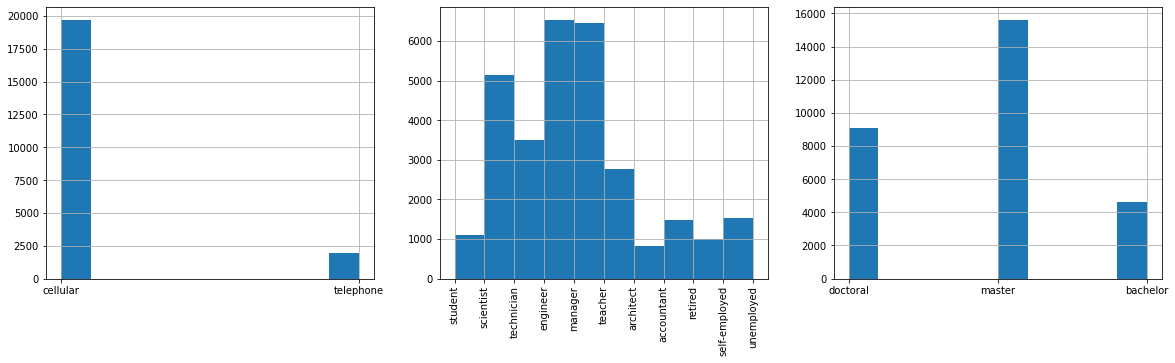

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
df['device'].hist()
plt.subplot(1,3,2)
df['profession'].hist()
plt.xticks(rotation='vertical')
plt.subplot(1,3,3)
df['education'].hist();

In front of these plots :

- We can have the idea to replace all the unknown device by 'cellular' since it is the case for a vast majority of the known devices. 

- The variable 'education' is ordinal since we can have a notion of order with the education level. We can then consider the median of the distribution of the 'education' as our representant for the unknown values. So let replace the unknown 'education' with 'master'. It should not change a lot our distribution since unknown values for this feature represents only 6% of our dataset.

- Concerning the variable 'profession', it's a categorical feature and so we can't reasonably consider a notion of 'median'. Nevertheless, intuitively we can feel that the age and the level of education can help us to derive the profession. Hence, I propose for instance, to use a RandomForest to predict the unknown profession according to the age and the education level of the persons. I chose that model since I am considering here 2 features of different natures (numerical/categorical).

In [ ]:
df['profession'].value_counts()/(df['profession'].value_counts().sum())
df['education'].value_counts()/(df['education'].value_counts().sum())

master      0.533666
doctoral    0.309534
bachelor    0.156800
Name: education, dtype: float64

In [ ]:
df['device']=df['device'].replace({np.nan:"cellular"})
df['education']=df['education'].replace({np.nan:"master"})
df['education']=df["education"].replace({"master":2,"doctoral":3,"bachelor":1})

In [ ]:
features=['age','education']
no_nan_index=df['profession'].dropna().index
X=(df.loc[no_nan_index])[features]
y=df['profession'].loc[X.index]

#stratify=y enables to keep the same proportion of classes in our training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y) 

predict_profession = RandomForestClassifier(n_estimators=500,max_depth=10,min_samples_leaf=50,random_state=42)
predict_profession.fit(X_train,y_train)
print(accuracy_score(y_test,predict_profession.predict(X_test)))

profession_to_predict=df[df['profession'].isnull()==True][features]
predictions=predict_profession.predict(profession_to_predict)

df['profession'][df['profession'].isnull()==True]=predictions

0.41905703923508075


- Apparently, the result of the RandomForest doesn't seem very good. However, if we consider a random classifier, we will get an accuracy of 0.09 and if we consider to replace the unknown values by the mode of the feature 'profession', we will get an accuracy of 0.22. Thus, our model is finally not so bad compared to these baselines.

Let see now the new distributions of the features 'education','profession' and 'device'.

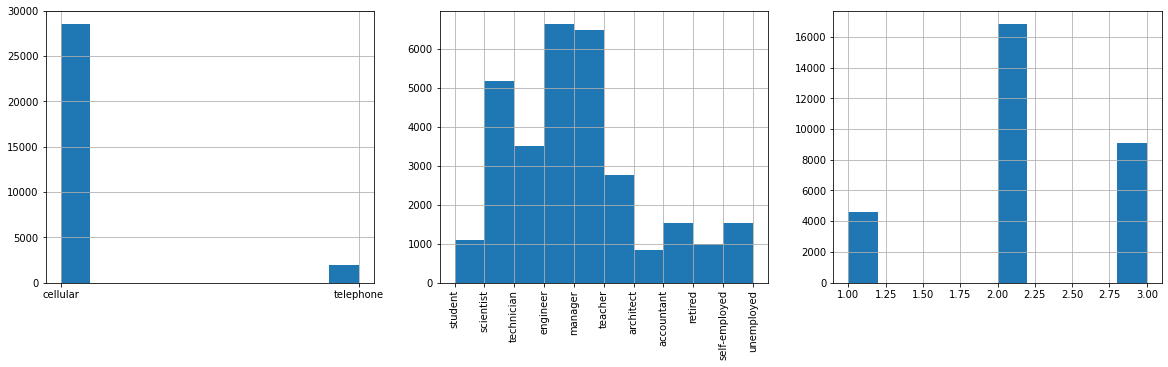

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
df['device'].hist()
plt.subplot(1,3,2)
df['profession'].hist()
plt.xticks(rotation='vertical')
plt.subplot(1,3,3)
df['education'].hist();

- The distributions haven't change much so I think we can keep this preprocessing

Now, we have binary variables in our dataset that we can change to 0 and 1 so that it can be used with our future models. Moreover, we have categorical features that we are going to change into dummy variables in order to avoid that a model consider them as ordinal features. (Notably, if we want to consider a decision tree or a random forest, replacing these categorical features by numbers will lead us to 'meaningless' rules of the style **if profession lower than scientist**)

In [ ]:
df[['subscribed','loan','mortgage','credit','positive']]=df[['subscribed','loan','mortgage','credit','positive']].astype(int)

In [ ]:
df=pd.get_dummies(df,drop_first=True)

## Test

- We are going to consider the **exact** same preprocessing for the test set.

In [ ]:
df_test = pd.read_csv("./marketing_campaigns_test.csv", index_col=0)
df_test.head()

,status,age,n_child,education,profession,device,account_balance,loan,mortgage,credit,positive,campaign_type,n_contact,l_date,l_call_duration,p_outcome,n_p_contact,p_days
id,,,,,,,,,,,,,,,,,,
512496,divorced,37,unknown,master,scientist,cellular,-12,False,True,False,False,phone call,2,04-Feb,32,unknown,0,-1
488528,married,46,unknown,bachelor,manager,unknown,-231,False,True,False,False,phone call,1,27-May,91,unknown,0,-1
499524,single,29,unknown,doctoral,manager,cellular,1867,False,False,False,True,phone call,3,28-Jul,42,unknown,0,-1
506539,married,46,unknown,unknown,unknown,unknown,619,False,False,False,True,phone call,1,13-Nov,652,unknown,0,-1
515863,married,31,unknown,doctoral,manager,cellular,-202,False,True,False,False,phone call,2,20-Apr,493,unknown,0,-1


In [ ]:
df_test=df_test.replace(['unknown'],np.nan)

df_test=df_test.drop(['l_date','n_child','p_outcome','campaign_type','n_p_contact','p_days'],axis=1)
df_test[['loan','mortgage','credit','positive']]=df_test[['loan','mortgage','credit','positive']].astype(int)
df_test['education']=df_test['education'].replace({np.nan:"master"})
df_test['education']=df_test["education"].replace({"master":2,"doctoral":3,"bachelor":1})
df_test['device']=df_test['device'].replace({np.nan:"cellular"})


profession_to_predict=df_test[df_test['profession'].isnull()==True][features]
predictions=predict_profession.predict(profession_to_predict)

df_test['profession'][df_test['profession'].isnull()==True]=predictions

In [ ]:
#check that there is no more unknown values
df_test.isnull().sum()

status             0
age                0
education          0
profession         0
device             0
account_balance    0
loan               0
mortgage           0
credit             0
positive           0
n_contact          0
l_call_duration    0
dtype: int64

In [ ]:
df_test=pd.get_dummies(df_test,drop_first=True)

# Cutting and Modeling

In [ ]:
df.head()

,age,education,account_balance,loan,mortgage,credit,positive,n_contact,l_call_duration,subscribed,status_married,status_single,profession_architect,profession_engineer,profession_manager,profession_retired,profession_scientist,profession_self-employed,profession_student,profession_teacher,profession_technician,profession_unemployed,device_telephone
id,,,,,,,,,,,,,,,,,,,,,,,
512491,32,3,300,0,1,0,1,2,175,0,1,0,0,0,0,0,0,0,1,0,0,0,0
495633,45,2,1339,0,1,0,1,1,322,0,1,0,0,0,0,0,1,0,0,0,0,0,0
507946,54,2,2832,0,1,0,1,1,67,0,1,0,0,0,0,0,0,0,0,0,1,0,1
491165,30,2,530,1,1,0,1,1,45,0,1,0,0,1,0,0,0,0,0,0,0,0,0
494627,40,3,-922,1,1,1,0,2,39,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB 
from sklearn import svm
from scipy import stats 
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from tqdm.notebook import tqdm

In [ ]:
numeric =['age','account_balance','n_contact','l_call_duration']
discrete= df.drop(numeric+['subscribed'],axis=1).columns


X = df.drop('subscribed', axis=1)
y = df['subscribed']


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y) 

X_train[numeric].head()

,age,account_balance,n_contact,l_call_duration
id,,,,
524538,32,852,1,151
513680,65,654,1,293
494158,47,268,1,59
527076,34,475,3,714
522066,44,7046,1,373


In [ ]:
X_train.head()

,age,education,account_balance,loan,mortgage,credit,positive,n_contact,l_call_duration,status_married,status_single,profession_architect,profession_engineer,profession_manager,profession_retired,profession_scientist,profession_self-employed,profession_student,profession_teacher,profession_technician,profession_unemployed,device_telephone
id,,,,,,,,,,,,,,,,,,,,,,
524538,0.181818,3,0.081296,0,0,0,1,0.000000,0.033665,0,1,0,0,1,0,0,0,0,0,0,0,0
513680,0.610390,1,0.079299,0,0,0,1,0.000000,0.065748,1,0,1,0,0,0,0,0,0,0,0,0,0
494158,0.376623,2,0.075405,0,0,0,1,0.000000,0.012878,0,0,0,0,0,0,0,0,0,1,0,0,0
527076,0.207792,2,0.077493,0,0,0,1,0.032258,0.160868,0,1,0,0,0,0,0,1,0,0,0,0,0
522066,0.337662,3,0.143779,0,0,0,1,0.000000,0.083823,1,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
# create a scaler object
scaler = MinMaxScaler()
# fit and transform the data
X_train[numeric] = scaler.fit_transform(X_train[numeric].values)
X_valid[numeric] = scaler.transform(X_valid[numeric].values)

X_train.head()

,age,education,account_balance,loan,mortgage,credit,positive,n_contact,l_call_duration,status_married,status_single,profession_architect,profession_engineer,profession_manager,profession_retired,profession_scientist,profession_self-employed,profession_student,profession_teacher,profession_technician,profession_unemployed,device_telephone
id,,,,,,,,,,,,,,,,,,,,,,
524538,0.181818,3,0.081296,0,0,0,1,0.000000,0.033665,0,1,0,0,1,0,0,0,0,0,0,0,0
513680,0.610390,1,0.079299,0,0,0,1,0.000000,0.065748,1,0,1,0,0,0,0,0,0,0,0,0,0
494158,0.376623,2,0.075405,0,0,0,1,0.000000,0.012878,0,0,0,0,0,0,0,0,0,1,0,0,0
527076,0.207792,2,0.077493,0,0,0,1,0.032258,0.160868,0,1,0,0,0,0,0,1,0,0,0,0,0
522066,0.337662,3,0.143779,0,0,0,1,0.000000,0.083823,1,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
print('proportion in the train : ',np.unique(y_train,return_counts=True)[1]/np.unique(y_train,return_counts=True)[1].sum())
print('proportion in the valid : ', np.unique(y_valid,return_counts=True)[1]/np.unique(y_valid,return_counts=True)[1].sum())

proportion in the train :  [0.88465245 0.11534755]
proportion in the valid :  [0.88466579 0.11533421]


- Remarks :

We are working with a highly imbalanced and so the accuracy is not the more appropriate metric for our problem. Indeed, taking the "shy" classifier that always predict that the prospect won't subscribe to our insurance plan results in an accuracy of 88% in our valid test, which seems very good while this model is super useless. 

Let us describe that we want :

We want a model able to predict a reasonable quantity of prospects that are susceptible to subscribe to our insurance plan while trying to be the most precise possible in the prediction.

In reality, we want to minimize the number of false positive and false negative because, predict that a prospect will subscribed while it wouldn't, results in a loss of time and, predict that a prospect won't subscribed while it would, results in a loss of money. However, since the event 'subscribe to the insurance plan' is a rare event, we have less chance to observe false negative.

So at the end, we want a model with a good precision and a good recall for the positive class (it will not be difficult to obtain a good precision and a good recall for the other class). And hence, we will use the F1-score to evaluate our models.

If we have a good precision of the positive class but a low recall, this will mean that our model will not make many mistakes for the prediction of the positive class but he won't make a lot of predictions for this class. This is not wanted because we want to catch a maximum of clients if possible. 

On the contrary, if we have a low precision but a good recall that will mean that our model is too confident and it will not enable us to save times making us calling almost all the prospects in our database...

**So at final, the F1-score is a good tradeoff to target**

Nevertheless, if we do like always, selecting a threshold of 50% for our final decision based on the probabilities returned by our model, we risk to not benefit of maximum potential of our model. Indeed, the threshold can't be a good reference in our case since we work with only 12% of samples in our positive class. In that case, **we need find the best threshold for each model, that's to say, the threshold enabling to maximize the f1-score on our validation test**. 

In order to compare our model, we can use as our performance metric the **'Area under the Precision Recall Curve'**. This curve is a plot of precision against recall varying the threshold on the probabilities returned by our models. Since we are especially interested by the precision and the recall of our positive class, it is a perfect metric enabling to assess to what extent a model is better than other considering what we said before. 

During the course, we've seen also the 'Area under the Roc curve' but it is not appropriate here since we are working with a highly imbalanced dataset. Indeed, that metric take into account to what extent we succeed in predicting a class whatever its nature (positive and negative), and since it is very easy for a model to predict 0, we can easily have a good AUC while having a not really relevant model.





In [ ]:
def plot_prc_and_give_acc_and_auc(clf,X_train,y_train,X_valid,y_valid):
  '''
  @clf : the model for which we want to plot the prc
  @X_train : the training set used by clf
  @X_valid : the testing set used to compute the curve

  this function plot the precision recall curve of clf and print the accuracy score (considering a threshold of 0.5) a
  and the AUC
  '''

  clf.fit(X_train, y_train)
  plot_precision_recall_curve(clf,X_valid,y_valid);
  y=clf.predict(X_valid)
  y_proba=clf.predict_proba(X_valid)[:,1]
  print(f'Accuracy_Score : {accuracy_score(y,y_valid)}')
  print(f'AUC : {roc_auc_score(y_valid,y_proba)}')

In [ ]:
def best_threshold(clf,X_valid,y_valid):
    '''
  @clf : the model for which we want to obtain the best threshold for making the final decision
  @X_train : the training set used by clf
  @X_valid : the testing set used to compute the curve

  This function return the threshold enabling to obtain the best F1-score for the positive class on the validation set for clf
  '''
    yhat=clf.predict_proba(X_valid)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_valid, yhat)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.nanargmax(fscore)

    print('F1-score : ', fscore[ix])
    print('threshold : ', thresholds[ix])

    return thresholds[ix]

In [ ]:
def best_f1_score(y_pred,y_true,threshold):
    '''
    @y_pred : probabilities to belonging to the positive class returned by a certain model
    @y_true : real classes, target
    @threshold : best threshold enabling to maximize the F1-score of the positive class on the validation

    This function return the confusion matrix obtained with the best threshold
    '''
    preds=(y_pred>threshold).astype(int)
    print('Number of true positive :',preds[y_true==1].sum())
    print('Accuracy with the best threshold :', accuracy_score(y_true,preds))
    print(metrics.classification_report(y_true,preds))

**Description of our strategy to obtain the best model** 

- We are going to tune some hyperparameters for different models using a cross validation on the train set.
- Then, we will compare all the models with their better hyperparameters thanks to the area under the precision-recall curve on the validation test
- At the end, we will use our best model on the test set provided considering the best threshold to apply on the probabilities returned by this model.

## KNN 

At first, let's give a chance to simple models. Who knows ? they can be useful...

The K-NN is intuitive, considering a new observation, it predicts the belonging to a class according to the classes of the points of our dataset that are, the most "closest" to this new observation. However, the notion of closeness is different for numerical/continuous and discrete features. 

Hence, we propose to consider two versions of the training dataset. One with only numerical features (distance=L2) and one with only discrete features (distance=Hamming).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### Working with the Euclidian distance | Numerical features

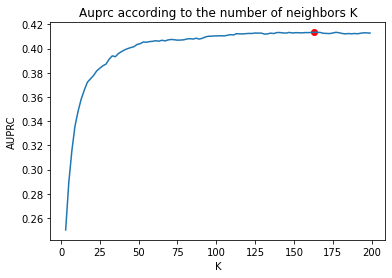

In [ ]:
K=np.arange(3,201,2)

auprc_means=[]
kf = KFold(n_splits=5, shuffle=True, random_state=42) #for cross validation
X_cv=X_train[numeric].values
y_cv=y_train.values

for k in tqdm(K):
  auprc=[]
  clf = KNeighborsClassifier(n_neighbors=k)
  for train_index, test_index in kf.split(X_cv):
    
      # split to train and test
      X_tr, X_test = X_cv[train_index], X_cv[test_index]
      y_tr, y_test = y_cv[train_index], y_cv[test_index]

      # train the model and make a prediction
      clf.fit(X_tr,y_tr)
      y_pred = clf.predict_proba(X_test)[:,1]
      auprc.append(average_precision_score(y_test,y_pred))

  auprc_means.append(np.mean(auprc))  # print the results
  # print("Classifier: ", clf)
  # print("Mean of AUPRC: ",np.mean(auprc))


plt.plot(K,auprc_means)
plt.scatter(K[np.argmax(auprc_means)],np.max(auprc_means),c='red')
plt.title('Auprc according to the number of neighbors K')
plt.xlabel('K')
plt.ylabel('AUPRC');

In [ ]:
print(K[np.argmax(auprc_means)])

163


Accuracy_Score : 0.8857579729139362
AUC : 0.7745737467265245
F1-score :  0.37483266398929055
Number of true positive : 264
0.8016601135867191
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      4050
           1       0.29      0.50      0.37       528

    accuracy                           0.80      4578
   macro avg       0.61      0.67      0.63      4578
weighted avg       0.85      0.80      0.82      4578



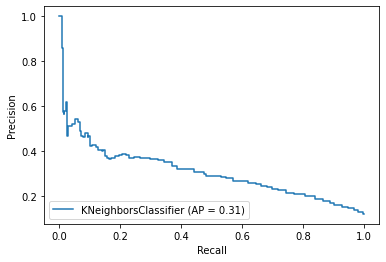

In [ ]:
clf=KNeighborsClassifier(n_neighbors=163)
clf.fit(X_train,y_train)
plot_prc_and_give_acc_and_auc(clf,X_train,X_valid)
best_f1_score(clf.predict_proba(X_valid)[:,1],y_valid,best_threshold(clf,X_valid,y_valid))

- Considering all the prospects that are subscribed in our valid test, the best model that we can obtain with the KNN strategy has predicted 50% of them. That is a rather good rate.

- Among all the positive prediction, the true ones which were positive represent only a fraction of 29%. Hence, if we have used that model on the valid test, our predictions for the positive class will be good approximatively 30% the time and hence, we are not loosing so much time.

Let see what we would obtain with the natural threshold '0.5' that we could have used naively.

In [ ]:
best_f1_score(clf.predict_proba(X_valid)[:,1],y_valid,0.5)

Number of true positive : 5
0.8857579729139362
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      4050
           1       1.00      0.01      0.02       528

    accuracy                           0.89      4578
   macro avg       0.94      0.50      0.48      4578
weighted avg       0.90      0.89      0.83      4578



- Considering all the prospects that are subscribed in our valid test, the model has predicted only 1% of them. That is a really bad rate.

- Among all the positive prediction, the true ones which were positive represent a fraction of 100%. Hence, if we have used that model on the valid test, the predictions for the positive class will be correct all the time.

What can we say ? In fact, this model is too 'shy', it prefers to be cautious and predict that a client will subscribe only if it is really really sure. So, at the end, the model predict almost never that a client that subscribe but at least, it didn't make false positive... In practice, this model is not helpful since we risk to loose a lot of money with this 'no-risk' behaviour.

**We see here the importance of the f1-score on the positive class !**

**Here, doing the difference between the amount of true positive of our two models, we obtain 259. Hence, taking the second model rather than the first one implies that we will loose 259 subscriptions**

### Working with the Hamming distance | Categorical features

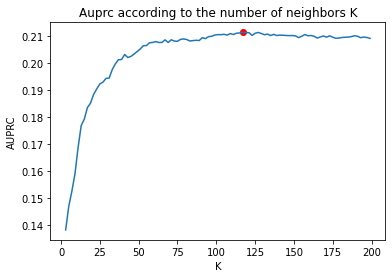

In [ ]:
K=np.arange(3,201,2)

auprc_means=[]
kf = KFold(n_splits=5, shuffle=True, random_state=42) #for cross validation
X_cv=X_train[discrete].values
y_cv=y_train.values

for k in tqdm(K):
  auprc=[]
  clf = KNeighborsClassifier(n_neighbors=k,metric='hamming')
  for train_index, test_index in kf.split(X_cv):
    
      # split to train and test
      X_tr, X_test = X_cv[train_index], X_cv[test_index]
      y_tr, y_test = y_cv[train_index], y_cv[test_index]

      # train the model and make a prediction
      clf.fit(X_tr,y_tr)
      y_pred = clf.predict_proba(X_test)[:,1]
      auprc.append(average_precision_score(y_test,y_pred))

  auprc_means.append(np.mean(auprc))  # print the results
  # print("Classifier: ", clf)
  # print("Mean of AUPRC: ",np.mean(auprc))


plt.plot(K,auprc_means)
plt.scatter(K[np.argmax(auprc_means)],np.max(auprc_means),c='red')
plt.title('Auprc according to the number of neighbors K')
plt.xlabel('K')
plt.ylabel('AUPRC');

Considering the AUPRCs obtained, we see that working with the categorical features, the knn and the hamming doesn't enable to obtain a more efficient model than the previous one.

- 

## SVM

The idea of the SVM is to embed the features into a abstract space where we hope that our classification problem will reduce to a case where our boundary will be linear.

To embed the features, we use a kernel. 

In the case of the 'linear' kernel, we are not embedding our feature into an other space since we try precisely to estimate a linear boundary between our classes in our initial feature space. Let's try to see if it's a good idea.

### Linear kernel


Classifier:  SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Mean of AUPRC:  0.37241071385553626



Classifier:  SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Mean of AUPRC:  0.3646081772360727



Classifier:  SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Mean of AUPRC:  0.36262770498849817



Classifier:  SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Mean of AUPRC:  0.37585405673539624



Classifier:  SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Mean of AUPRC:  0.36822545913865473


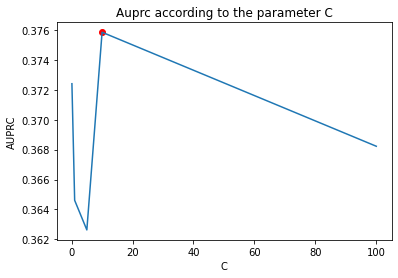

In [ ]:
C=[0.1,1,5,10,100]
auprc_means=[]
kf = KFold(n_splits=5, shuffle=True, random_state=42) #for cross validation
X_cv=X_train[numeric].values
y_cv=y_train.values

for c in C:
  auprc=[]
  clf = SVC(kernel='linear',C=c,probability=True)
  for train_index, test_index in tqdm(kf.split(X_cv)):
    
      # split to train and test
      X_train, X_test = X_cv[train_index], X_cv[test_index]
      y_train, y_test = y_cv[train_index], y_cv[test_index]

      # train the model and make a prediction
      clf.fit(X_train,y_train)
      y_pred = clf.predict_proba(X_test)[:,1]
      auprc.append(average_precision_score(y_test,y_pred))

  auprc_means.append(np.mean(auprc))  # print the results
  print("Classifier: ", clf)
  print("Mean of AUPRC: ",np.mean(auprc))


plt.plot(C,auprc_means)
plt.scatter(C[np.argmax(auprc_means)],np.max(auprc_means),c='red')
plt.title('Auprc according to the parameter C')
plt.xlabel('C')
plt.ylabel('AUPRC');

Accuracy_Score : 0.8846657929226737
AUC : 0.7560084642723531
F1-score :  0.4268502581755594
Number of true positive : 247
0.8543031891655745
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      4050
           1       0.39      0.47      0.43       528

    accuracy                           0.85      4578
   macro avg       0.66      0.69      0.67      4578
weighted avg       0.87      0.85      0.86      4578



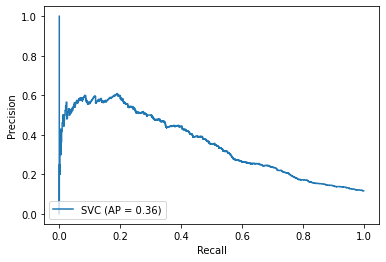

In [ ]:
clf = SVC(kernel='linear',C=10,probability=True)
clf.fit(X_train[numeric],y_train)
plot_prc_and_give_acc_and_auc(clf,X_train[numeric],X_valid[numeric])
best_f1_score(clf.predict_proba(X_valid[numeric])[:,1],y_valid,best_threshold(clf,X_valid[numeric],y_valid))

- Considering all the prospects that are subscribed in our valid test, the best model that we can obtain with the SVM(kernel='linear') strategy has predicted 47% of them. That is a rather good rate but slightly lower than the one obtained previously with the KNN.

- Among all the positive prediction, the true ones which were positive represent only a fraction of 39%. Hence, if we have used that model on the valid test, our predictions for the positive class will be good approximatively 39% of the time and hence, we are loosing 10% less time than before. 

In that case, we can consider that we have found a better model and the f1-score confirms our intuition.

Let see what we would obtain with the natural threshold '0.5' that we could have used naively.

In [ ]:
best_f1_score(clf.predict_proba(X_valid[numeric])[:,1],y_valid,0.5)

Number of true positive : 152
0.8837920489296636
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      4050
           1       0.49      0.29      0.36       528

    accuracy                           0.88      4578
   macro avg       0.70      0.62      0.65      4578
weighted avg       0.86      0.88      0.87      4578



- Considering all the prospects that are subscribed in our valid test, the model has predicted 26% of them. That is a rather bad rate, it's 21% less compared to the previous model.

- Among all the positive prediction of the model, the true ones which were positive represent only a fraction of 52%. Hence, if we have used that model on the valid test, our predictions for the positive class will be good approximatively 52% of the time and hence, we are loosing 13% less time than before. 

We retrieve again the idea that, be cautious to predict the positive class enable to be more precise. However, that also imply a potential lost of money.

**Here, doing the difference between the amount of true positive of our two models, we obtain 105. Hence, taking the second model rather than the first one implies that we will loose 105 subscriptions**

### Rbf Kernel

When we use the 'rbf' kernel, we are doing an embedding of our features using a gaussian kernel translating the notion of distance in our initial space into a similarity score in the final space. Let's try if we can get better results with such transformations.

In [ ]:
clf = SVC(kernel='rbf',probability=True)

gammas=[0.1,1,5,10]
C=[0.1,1,10]


param_grid = {'gamma': gammas,
              'C': C}

grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2,scoring='average_precision')

In [ ]:
grid_search.fit(X_train, y_train)

with open('best_param_svm_rbf.pickle', 'wb') as f:
    pickle.dump(grid_search.best_params_, f)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 42.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 79.3min finished


In [ ]:
grid_search.best_params_

{'C': 1, 'gamma': 0.1}

Accuracy_Score : 0.8846657929226737
AUC : 0.5765366629255518


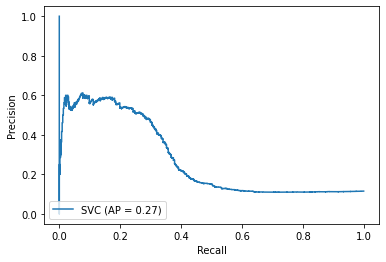

In [ ]:
clf=SVC(kernel='rbf',probability=True,C=1,gamma=0.1)
clf.fit(X_train[numeric],y_train)

plot_prc_and_give_acc_and_auc(clf,X_train[numeric],X_valid[numeric])
best_f1_score(clf.predict_proba(X_valid)[:,1],y_valid,best_threshold(clf,X_valid,y_valid))

## Random Forest

### Random Search

In [ ]:
from sklearn import ensemble
clf = ensemble.RandomForestClassifier()

n_estimators = [int(x) for x in np.arange(100,1100,100)]

max_features = ['auto', 'log2', 2, 5, 8]

max_depth = [int(x) for x in np.arange(5,31,10)]
max_depth.append(None)

min_samples_split = [2, 5, 10, 15]

min_samples_leaf = [50,100,500]

max_samples = [0.1, 0.3, 0.5, 0.7]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}

random_search = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 5,
                               verbose = 2, random_state = 42, n_jobs = -1,scoring='average_precision')

random_search.fit(X_train, y_train)

with open('best_param_random_rf.pickle', 'wb') as f:
    pickle.dump(random_search.best_params_, f)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 23.6min finished


In [ ]:
random_search.best_params_

{'max_depth': 15,
 'max_features': 8,
 'max_samples': 0.5,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'n_estimators': 100}

Accuracy_Score : 0.8942769768457842
AUC : 0.8636228020950242


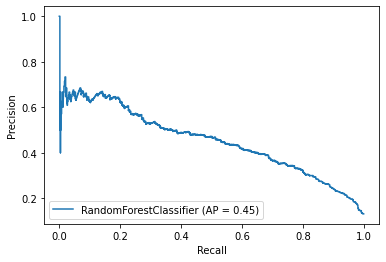

In [ ]:
clf = RandomForestClassifier(n_estimators=100,max_features=8,max_depth=15,max_samples=0.5,min_samples_leaf=50,min_samples_split=2)
plot_prc_and_give_acc_and_auc(clf,X_train,X_valid)

### Grid Search

In [ ]:
clf =  ensemble.RandomForestClassifier(min_samples_leaf=50)

n_estimators = [90,100,110]

max_features = [7,8,9]

max_samples = [0.4, 0.5, 0.6]

max_depth = [10,15,20]

min_samples_split = [2,3,4]

param_grid = {'n_estimators': n_estimators,
               'max_depth' : max_depth,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'max_samples' : max_samples}

grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2,scoring='average_precision')

grid_search.fit(X_train, y_train)

with open('best_param_grid_rf.pickle', 'wb') as f:
    pickle.dump(grid_search.best_params_, f)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 10.2min finished


In [ ]:
grid_search.best_params_

{'max_depth': 20,
 'max_features': 7,
 'max_samples': 0.6,
 'min_samples_split': 4,
 'n_estimators': 100}

Accuracy_Score : 0.8925294888597641
AUC : 0.8641806958473626
F1-score :  0.5036710719530104
threshold :  0.22305112179662864
Number of true positive : 342
Accuracy with the best threshold : 0.8521188291830494
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      4050
           1       0.41      0.65      0.50       528

    accuracy                           0.85      4578
   macro avg       0.68      0.76      0.71      4578
weighted avg       0.89      0.85      0.87      4578



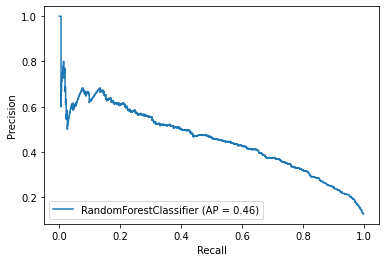

In [ ]:
clf = RandomForestClassifier(n_estimators=100,max_features=7,max_depth=20,max_samples=0.6,min_samples_leaf=50,min_samples_split=4,random_state=0)
clf.fit(X_train,y_train)
plot_prc_and_give_acc_and_auc(clf,X_train,X_valid)
best_f1_score(clf.predict_proba(X_valid)[:,1],y_valid,best_threshold(clf,X_valid,y_valid))

In [ ]:
best_f1_score(clf.predict_proba(X_valid)[:,1],y_valid,0.5)

Number of true positive : 108
0.8949322848405418
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4050
           1       0.64      0.20      0.31       528

    accuracy                           0.89      4578
   macro avg       0.77      0.59      0.63      4578
weighted avg       0.87      0.89      0.87      4578



## Logistic Regression 


Classifier:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Mean of AUPRC:  0.39035136734977555



Classifier:  LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Mean of AUPRC:  0.3911973791351952



Classifier:  LogisticRegression(C=0.30000000000000004, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Mean of AUPRC:  0.39138690955160105



Classifier:  LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Mean of AUPRC:  0.3914186097698262



Classifier:  LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Mean of AUPRC:  0.39150289080039957



Classifier:  LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Mean of AUPRC:  0.39147881165013504



Classifier:  LogisticRegression(C=0.7000000000000001, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Mean of AUPRC:  0.3914710461698502



Classifier:  LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Mean of AUPRC:  0.39147457572459954



Classifier:  LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Mean of AUPRC:  0.3914335662505256


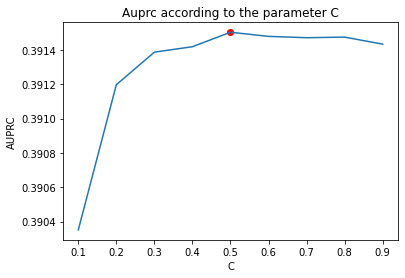

In [ ]:
from sklearn.linear_model import LogisticRegression

C=np.arange(0.1,1,0.1)
auprc_means=[]
kf = KFold(n_splits=5, shuffle=True, random_state=42) #for cross validation
X_cv=X_train[numeric].values
y_cv=y_train.values

for c in C:
  auprc=[]
  clf = LogisticRegression(C=c)
  for train_index, test_index in tqdm(kf.split(X_cv)):
    
      # split to train and test
      X_tr, X_test = X_cv[train_index], X_cv[test_index]
      y_tr, y_test = y_cv[train_index], y_cv[test_index]

      # train the model and make a prediction
      clf.fit(X_tr,y_tr)
      y_pred = clf.predict_proba(X_test)[:,1]
      auprc.append(average_precision_score(y_test,y_pred))

  auprc_means.append(np.mean(auprc))  # print the results
  print("Classifier: ", clf)
  print("Mean of AUPRC: ",np.mean(auprc))


plt.plot(C,auprc_means)
plt.scatter(C[np.argmax(auprc_means)],np.max(auprc_means),c='red')
plt.title('Auprc according to the parameter C')
plt.xlabel('C')
plt.ylabel('AUPRC');

Accuracy_Score : 0.8875054608999563
AUC : 0.8023251028806584
F1-score :  0.4308426073131955
threshold :  0.15209472625356096
Number of true positive : 270
Accuracy with the best threshold : 0.8433813892529489
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      4050
           1       0.37      0.51      0.43       528

    accuracy                           0.84      4578
   macro avg       0.65      0.70      0.67      4578
weighted avg       0.87      0.84      0.85      4578



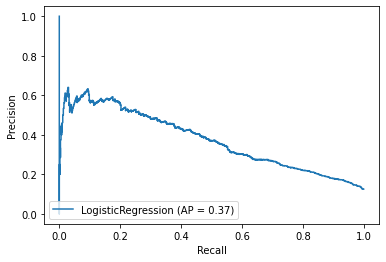

In [ ]:
clf = LogisticRegression(C=0.5,random_state=0)
clf.fit(X_train[numeric],y_train)
plot_prc_and_give_acc_and_auc(clf,X_train[numeric],X_valid[numeric])
best_f1_score(clf.predict_proba(X_valid[numeric])[:,1],y_valid,best_threshold(clf,X_valid[numeric],y_valid))

528 nb de personne qui sont vraiment 1 

270 nb de personne que on a predit un et qui sont vraiment 1 
recall 270/528

270 nb de personne que on a predit un et qui sont vraiment 1 

730 (270/0.37) nb de personne que on a predit un 
precision 270/730




```
# This is formatted as code
```

## Naives Bayes

### Categorical features


Classifier:  MultinomialNB(alpha=0.0, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.1957720940058521



Classifier:  MultinomialNB(alpha=0.25, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19576270311309374



Classifier:  MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19575754613061022



Classifier:  MultinomialNB(alpha=0.75, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19574250051572367



Classifier:  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.1957797820180749



Classifier:  MultinomialNB(alpha=1.25, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19577035842525475



Classifier:  MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.1957694858357748



Classifier:  MultinomialNB(alpha=1.75, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19571111072427258



Classifier:  MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19570496751517202



Classifier:  MultinomialNB(alpha=2.25, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.1957081158982415



Classifier:  MultinomialNB(alpha=2.5, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.1956911402841178



Classifier:  MultinomialNB(alpha=2.75, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19565366182134278



Classifier:  MultinomialNB(alpha=3.0, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19561284300383894



Classifier:  MultinomialNB(alpha=3.25, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19561146034357235



Classifier:  MultinomialNB(alpha=3.5, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19560812763685673



Classifier:  MultinomialNB(alpha=3.75, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.1955101221764651



Classifier:  MultinomialNB(alpha=4.0, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.1954988467809215



Classifier:  MultinomialNB(alpha=4.25, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19549726799639422



Classifier:  MultinomialNB(alpha=4.5, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19546367288079805



Classifier:  MultinomialNB(alpha=4.75, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19545796187220438



Classifier:  MultinomialNB(alpha=5.0, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.195399543166968



Classifier:  MultinomialNB(alpha=5.25, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19540059843902252



Classifier:  MultinomialNB(alpha=5.5, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19538514935760298



Classifier:  MultinomialNB(alpha=5.75, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19544156025607365



Classifier:  MultinomialNB(alpha=6.0, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19543747409823453



Classifier:  MultinomialNB(alpha=6.25, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19539161974619898



Classifier:  MultinomialNB(alpha=6.5, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.1953627061899091



Classifier:  MultinomialNB(alpha=6.75, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19533309729068413



Classifier:  MultinomialNB(alpha=7.0, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19531623685632604



Classifier:  MultinomialNB(alpha=7.25, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19528113384747858



Classifier:  MultinomialNB(alpha=7.5, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19528166579601622



Classifier:  MultinomialNB(alpha=7.75, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.1952594356136957



Classifier:  MultinomialNB(alpha=8.0, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.1952041750101298



Classifier:  MultinomialNB(alpha=8.25, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19526146850535722



Classifier:  MultinomialNB(alpha=8.5, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19523629373881876



Classifier:  MultinomialNB(alpha=8.75, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19522836852401232



Classifier:  MultinomialNB(alpha=9.0, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19519237835293324



Classifier:  MultinomialNB(alpha=9.25, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.1951723733515812



Classifier:  MultinomialNB(alpha=9.5, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19514033479588716



Classifier:  MultinomialNB(alpha=9.75, class_prior=None, fit_prior=True)
Mean of AUPRC:  0.19511885168294127


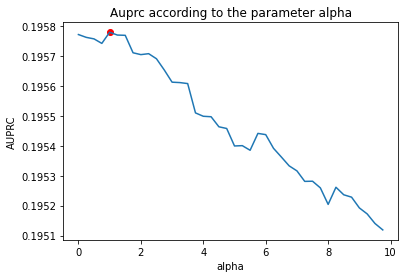

In [ ]:
from sklearn.naive_bayes import MultinomialNB

alphas=np.arange(0,10,0.25)
auprc_means=[]
kf = KFold(n_splits=5, shuffle=True, random_state=42) #for cross validation
X_cv=X_train[discrete].values
y_cv=y_train.values

for a in alphas:
  auprc=[]
  clf = MultinomialNB(alpha=a)
  for train_index, test_index in tqdm(kf.split(X_cv)):
    
      # split to train and test
      X_tr, X_test = X_cv[train_index], X_cv[test_index]
      y_tr, y_test = y_cv[train_index], y_cv[test_index]

      # train the model and make a prediction
      clf.fit(X_tr,y_tr)
      y_pred = clf.predict_proba(X_test)[:,1]
      auprc.append(average_precision_score(y_test,y_pred))

  auprc_means.append(np.mean(auprc))  # print the results
  print("Classifier: ", clf)
  print("Mean of AUPRC: ",np.mean(auprc))


plt.plot(alphas,auprc_means)
plt.scatter(alphas[np.argmax(auprc_means)],np.max(auprc_means),c='red')
plt.title('Auprc according to the parameter alpha')
plt.xlabel('alpha')
plt.ylabel('AUPRC');

### Numerical features

In [ ]:
from sklearn.naive_bayes import GaussianNB

kf = KFold(n_splits=5, shuffle=True, random_state=42) #for cross validation
X_cv=X_train[numeric].values
y_cv=y_train.values

auprc=[]
clf = GaussianNB()
for train_index, test_index in tqdm(kf.split(X_cv)):
  
    # split to train and test
    X_tr, X_test = X_cv[train_index], X_cv[test_index]
    y_tr, y_test = y_cv[train_index], y_cv[test_index]

    # train the model and make a prediction
    clf.fit(X_tr,y_tr)
    y_pred = clf.predict_proba(X_test)[:,1]
    auprc.append(average_precision_score(y_test,y_pred))

auprc_means.append(np.mean(auprc))  # print the results
print("Classifier: ", clf)
print("Mean of AUPRC: ",np.mean(auprc))


Classifier:  GaussianNB(priors=None, var_smoothing=1e-09)
Mean of AUPRC:  0.3762931323412501


Accuracy_Score : 0.8794233289646134
AUC : 0.7743579311634868
F1-score :  0.4172440338722094
threshold :  0.1372495814365769
Number of true positive : 270
Accuracy with the best threshold : 0.8344255133245959
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      4050
           1       0.35      0.51      0.42       528

    accuracy                           0.83      4578
   macro avg       0.64      0.69      0.66      4578
weighted avg       0.87      0.83      0.85      4578



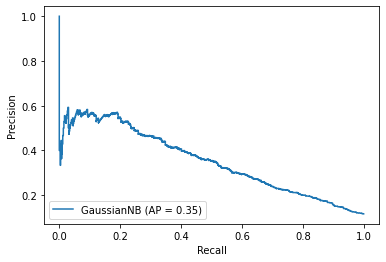

In [ ]:
clf = GaussianNB()
clf.fit(X_train[numeric],y_train)
plot_prc_and_give_acc_and_auc(clf,X_train[numeric],X_valid[numeric])
best_f1_score(clf.predict_proba(X_valid[numeric])[:,1],y_valid,best_threshold(clf,X_valid[numeric],y_valid))

In [ ]:
best_f1_score(clf.predict_proba(X_valid[numeric])[:,1],y_valid,0.5)

Number of true positive : 155
Accuracy with the best threshold : 0.8794233289646134
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      4050
           1       0.46      0.29      0.36       528

    accuracy                           0.88      4578
   macro avg       0.69      0.62      0.65      4578
weighted avg       0.86      0.88      0.87      4578



#PART3


In [ ]:
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import ADASYN
from matplotlib.pyplot import *




In [ ]:
X = df.drop('subscribed', axis=1)
y = df['subscribed']

In [ ]:
print(X)

        age  education  ...  profession_unemployed  device_telephone
id                      ...                                         
512491   32          3  ...                      0                 0
495633   45          2  ...                      0                 0
507946   54          2  ...                      0                 1
491165   30          2  ...                      0                 0
494627   40          3  ...                      0                 0
...     ...        ...  ...                    ...               ...
503479   60          3  ...                      0                 0
510801   43          2  ...                      0                 0
495601   34          2  ...                      0                 0
501424   58          3  ...                      0                 0
516748   33          3  ...                      0                 0

[30517 rows x 22 columns]


In [ ]:
print(y)

id 
512491    0
495633    0
507946    0
491165    0
494627    0
         ..
503479    0
510801    0
495601    0
501424    1
516748    0
Name: subscribed, Length: 30517, dtype: int64


In [ ]:
num_0 = len(df[df['subscribed']==0])
num_1 = len(df[df['subscribed']==1])
print(num_0,num_1)

26997 3520


##Oversampling

Adding more examples from the minority class
In this part, we want to create new points in our data set will represent the first category: we use the function sample to create the point , and finally we will have the same numbers of sample for the two categories  
the way to make it is to duplicate the rows with the minority class a lot of time ( so in the plot we will not see the points because they are exactly at the same place , it's the same points that we have duplicate)

1    26997
0    26997
Name: subscribed, dtype: int64


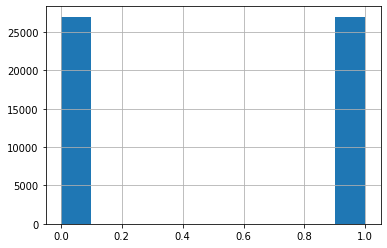

In [ ]:
oversampled_data = pd.concat([df[df['subscribed']==0] , df[df['subscribed']==1].sample(num_0, replace=True)])
print(oversampled_data['subscribed'].value_counts())
oversampled_data['subscribed'].hist()


we can see now that we have exactly the same proportions of 0 and 1 : 26997 samples 

```
# Ce texte est au format code
```



##Smote

in this algorithm we are going to create new points of the minority class [texte du lien](https://)

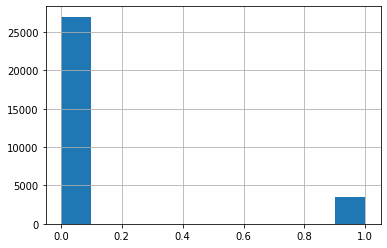

In [ ]:
df['subscribed'].hist()

In [ ]:
oversample = SMOTE()
smote_X, smote_y = oversample.fit_resample(X, y)

In [ ]:
from collections import Counter
counter = Counter(smote_y)
print(counter)


Counter({0: 26997, 1: 26997})


Once transformed, we can summarize the class distribution of the new transformed dataset, which would expect to now be balanced through the creation of many new synthetic examples in the minority class.

1    26997
0    26997
Name: subscribed, dtype: int64


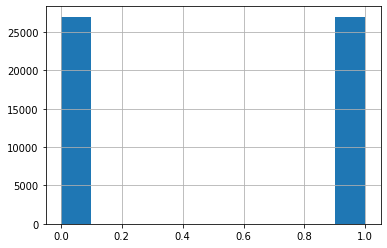

In [ ]:
smote_data = pd.concat([pd.DataFrame(smote_X),pd.DataFrame(smote_y, columns =['subscribed'])], axis =1)
print(smote_data['subscribed'].value_counts())
smote_data['subscribed'].hist()

We can update the example to first oversample the minority class to have 10 percent the number of examples of the majority class, then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class.

To implement this, we can specify the desired ratios as arguments to the SMOTE and RandomUnderSampler classes.
We can then chain these two transforms together into a Pipeline.

The Pipeline can then be applied to a dataset, performing each transformation in turn and returning a final dataset with the accumulation of the transform applied to it, in this case oversampling followed by undersampling.
The pipeline can then be fit and applied to our dataset just like a single transform:

In [ ]:
X = X_train
y = y = df['subscribed']

In [ ]:
X_train.head()

,age,education,account_balance,loan,mortgage,credit,positive,n_contact,l_call_duration,status_married,status_single,profession_architect,profession_engineer,profession_manager,profession_retired,profession_scientist,profession_self-employed,profession_student,profession_teacher,profession_technician,profession_unemployed,device_telephone
id,,,,,,,,,,,,,,,,,,,,,,
524538,0.181818,3,0.081296,0,0,0,1,0.000000,0.033665,0,1,0,0,1,0,0,0,0,0,0,0,0
513680,0.610390,1,0.079299,0,0,0,1,0.000000,0.065748,1,0,1,0,0,0,0,0,0,0,0,0,0
494158,0.376623,2,0.075405,0,0,0,1,0.000000,0.012878,0,0,0,0,0,0,0,0,0,1,0,0,0
527076,0.207792,2,0.077493,0,0,0,1,0.032258,0.160868,0,1,0,0,0,0,0,1,0,0,0,0,0
522066,0.337662,3,0.143779,0,0,0,1,0.000000,0.083823,1,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
y

id 
512491    0
495633    0
507946    0
491165    0
494627    0
         ..
503479    0
510801    0
495601    0
501424    1
516748    0
Name: subscribed, Length: 30517, dtype: int64

In [ ]:
X = X_train
y = y = df['subscribed']

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
smote2_X, smote2_y = pipeline.fit_resample(X, y)
smote2_data = pd.concat([pd.DataFrame(smote2_X),pd.DataFrame(smote2_y, columns =['subscribed'])], axis =1)
print(smote2_data['subscribed'].value_counts())
plot_data(smote2_data)

ValueError: ignored

In [ ]:
X.head()

,age,education,account_balance,loan,mortgage,credit,positive,n_contact,l_call_duration,status_married,status_single,profession_architect,profession_engineer,profession_manager,profession_retired,profession_scientist,profession_self-employed,profession_student,profession_teacher,profession_technician,profession_unemployed,device_telephone
id,,,,,,,,,,,,,,,,,,,,,,
524538,0.181818,3,0.081296,0,0,0,1,0.000000,0.033665,0,1,0,0,1,0,0,0,0,0,0,0,0
513680,0.610390,1,0.079299,0,0,0,1,0.000000,0.065748,1,0,1,0,0,0,0,0,0,0,0,0,0
494158,0.376623,2,0.075405,0,0,0,1,0.000000,0.012878,0,0,0,0,0,0,0,0,0,1,0,0,0
527076,0.207792,2,0.077493,0,0,0,1,0.032258,0.160868,0,1,0,0,0,0,0,1,0,0,0,0,0
522066,0.337662,3,0.143779,0,0,0,1,0.000000,0.083823,1,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
X_train.head()

,age,education,account_balance,loan,mortgage,credit,positive,n_contact,l_call_duration,status_married,status_single,profession_architect,profession_engineer,profession_manager,profession_retired,profession_scientist,profession_self-employed,profession_student,profession_teacher,profession_technician,profession_unemployed,device_telephone
id,,,,,,,,,,,,,,,,,,,,,,
524538,0.181818,3,0.081296,0,0,0,1,0.000000,0.033665,0,1,0,0,1,0,0,0,0,0,0,0,0
513680,0.610390,1,0.079299,0,0,0,1,0.000000,0.065748,1,0,1,0,0,0,0,0,0,0,0,0,0
494158,0.376623,2,0.075405,0,0,0,1,0.000000,0.012878,0,0,0,0,0,0,0,0,0,1,0,0,0
527076,0.207792,2,0.077493,0,0,0,1,0.032258,0.160868,0,1,0,0,0,0,0,1,0,0,0,0,0
522066,0.337662,3,0.143779,0,0,0,1,0.000000,0.083823,1,0,0,0,1,0,0,0,0,0,0,0,0


# Conclusion and prediction on the test set

- The best model we have found in term of f1-score (0.50) was obtained using the RandomForest strategy tuned carefully with a grid search. Looking at the details, we observed a rather good precision and recall for the model, much better than the others and so, we propose to use it for the genuine test set.

Perspectives : We could think about mixing the prediction given by the different models, taking into consideration the mean of the predicted probabilities for instance. We hadn't the time to do it properly with a grid search because it requires a lot of resources but we think that it could be a great idea in a real context.

In [ ]:
numeric_test_normalized=scaler.transform(df_test[numeric])
df_test[numeric]=numeric_test_normalized

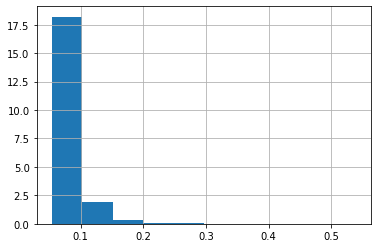

In [ ]:
X_valid['account_balance'].hist(density=True);

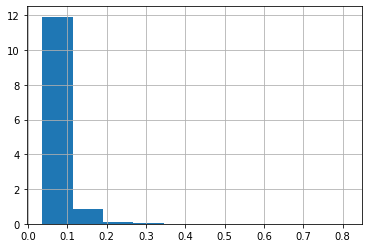

In [ ]:
df_test['account_balance'].hist(density=True);

In [ ]:
clf = RandomForestClassifier(n_estimators=100,max_features=7,max_depth=20,max_samples=0.6,min_samples_leaf=50,min_samples_split=4,random_state=0)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=7,
                       max_leaf_nodes=None, max_samples=0.6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
preds=(clf.predict_proba(df_test)[:,1]>0.22305112179662864).astype(int)

In [ ]:
np.unique(preds,return_counts=True)[1]/len(preds)

array([0.81182796, 0.18817204])

In [ ]:
df_test

,age,education,account_balance,loan,mortgage,credit,positive,n_contact,l_call_duration,status_married,status_single,profession_architect,profession_engineer,profession_manager,profession_retired,profession_scientist,profession_self-employed,profession_student,profession_teacher,profession_technician,profession_unemployed,device_telephone
id,,,,,,,,,,,,,,,,,,,,,,
512496,0.246753,2,0.072581,0,1,0,0,0.016129,0.006778,0,0,0,0,0,0,1,0,0,0,0,0,0
488528,0.363636,1,0.070372,0,1,0,0,0.000000,0.020108,1,0,0,0,1,0,0,0,0,0,0,0,0
499524,0.142857,3,0.091535,0,0,0,1,0.032258,0.009038,0,1,0,0,1,0,0,0,0,0,0,0,0
506539,0.363636,2,0.078946,0,0,0,1,0.000000,0.146859,1,0,0,1,0,0,0,0,0,0,0,0,0
515863,0.168831,3,0.070664,0,1,0,0,0.016129,0.110935,1,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500044,0.519481,2,0.072974,0,0,0,1,0.016129,0.055129,0,0,0,0,0,0,0,0,0,0,0,0,0
527278,0.324675,2,0.078482,0,1,0,1,0.000000,0.035698,1,0,0,1,0,0,0,0,0,0,0,0,0
489057,0.077922,1,0.081276,0,1,0,1,0.032258,0.012653,1,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
results=pd.DataFrame([])
results['predictions']=preds
results.index=df_test.index
results.to_csv('predictions_on_the_test_set.csv')